# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:29 - loss: 0.6939

  28/1875 [..............................] - ETA: 3s - loss: 0.5500   

  68/1875 [>.............................] - ETA: 2s - loss: 0.4478

 102/1875 [>.............................] - ETA: 2s - loss: 0.4069

 140/1875 [=>............................] - ETA: 2s - loss: 0.3784

 180/1875 [=>............................] - ETA: 2s - loss: 0.3574

 217/1875 [==>...........................] - ETA: 2s - loss: 0.3425

 251/1875 [===>..........................] - ETA: 2s - loss: 0.3311

 284/1875 [===>..........................] - ETA: 2s - loss: 0.3217

 322/1875 [====>.........................] - ETA: 2s - loss: 0.3122

 348/1875 [====>.........................] - ETA: 2s - loss: 0.3065

 376/1875 [=====>........................] - ETA: 2s - loss: 0.3009

 407/1875 [=====>........................] - ETA: 2s - loss: 0.2952

 439/1875 [======>.......................] - ETA: 2s - loss: 0.2898

 463/1875 [======>.......................] - ETA: 2s - loss: 0.2861

 495/1875 [======>.......................] - ETA: 2s - loss: 0.2814

 526/1875 [=======>......................] - ETA: 2s - loss: 0.2772

 558/1875 [=======>......................] - ETA: 2s - loss: 0.2732

 591/1875 [========>.....................] - ETA: 1s - loss: 0.2693

 618/1875 [========>.....................] - ETA: 1s - loss: 0.2663

 650/1875 [=========>....................] - ETA: 1s - loss: 0.2630

 679/1875 [=========>....................] - ETA: 1s - loss: 0.2602

 706/1875 [==========>...................] - ETA: 1s - loss: 0.2576

 737/1875 [==========>...................] - ETA: 1s - loss: 0.2549

 775/1875 [===========>..................] - ETA: 1s - loss: 0.2517

 812/1875 [===========>..................] - ETA: 1s - loss: 0.2487

 849/1875 [============>.................] - ETA: 1s - loss: 0.2460

 882/1875 [=============>................] - ETA: 1s - loss: 0.2436

 915/1875 [=============>................] - ETA: 1s - loss: 0.2413

 953/1875 [==============>...............] - ETA: 1s - loss: 0.2389

 987/1875 [==============>...............] - ETA: 1s - loss: 0.2367

1021/1875 [===============>..............] - ETA: 1s - loss: 0.2347

1051/1875 [===============>..............] - ETA: 1s - loss: 0.2330

1074/1875 [================>.............] - ETA: 1s - loss: 0.2317

1107/1875 [================>.............] - ETA: 1s - loss: 0.2299

1140/1875 [=================>............] - ETA: 1s - loss: 0.2282

1173/1875 [=================>............] - ETA: 1s - loss: 0.2265

1205/1875 [==================>...........] - ETA: 1s - loss: 0.2250

1238/1875 [==================>...........] - ETA: 0s - loss: 0.2234

1270/1875 [===================>..........] - ETA: 0s - loss: 0.2220

1304/1875 [===================>..........] - ETA: 0s - loss: 0.2205

1339/1875 [====================>.........] - ETA: 0s - loss: 0.2190

1373/1875 [====================>.........] - ETA: 0s - loss: 0.2176

1406/1875 [=====================>........] - ETA: 0s - loss: 0.2162

1439/1875 [======================>.......] - ETA: 0s - loss: 0.2150

1471/1875 [======================>.......] - ETA: 0s - loss: 0.2137

1503/1875 [=======================>......] - ETA: 0s - loss: 0.2126

1535/1875 [=======================>......] - ETA: 0s - loss: 0.2114

1568/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1602/1875 [========================>.....] - ETA: 0s - loss: 0.2091

1636/1875 [=========================>....] - ETA: 0s - loss: 0.2080

1669/1875 [=========================>....] - ETA: 0s - loss: 0.2069

1704/1875 [==========================>...] - ETA: 0s - loss: 0.2058

1737/1875 [==========================>...] - ETA: 0s - loss: 0.2048

1769/1875 [===========================>..] - ETA: 0s - loss: 0.2038

1802/1875 [===========================>..] - ETA: 0s - loss: 0.2029

1833/1875 [============================>.] - ETA: 0s - loss: 0.2020

1866/1875 [============================>.] - ETA: 0s - loss: 0.2010

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2008


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1070

  32/1875 [..............................] - ETA: 2s - loss: 0.1096

  60/1875 [..............................] - ETA: 3s - loss: 0.1098

  88/1875 [>.............................] - ETA: 3s - loss: 0.1099

 121/1875 [>.............................] - ETA: 2s - loss: 0.1101

 155/1875 [=>............................] - ETA: 2s - loss: 0.1102

 189/1875 [==>...........................] - ETA: 2s - loss: 0.1102

 222/1875 [==>...........................] - ETA: 2s - loss: 0.1102

 255/1875 [===>..........................] - ETA: 2s - loss: 0.1102

 288/1875 [===>..........................] - ETA: 2s - loss: 0.1102

 320/1875 [====>.........................] - ETA: 2s - loss: 0.1101

 352/1875 [====>.........................] - ETA: 2s - loss: 0.1100

 383/1875 [=====>........................] - ETA: 2s - loss: 0.1099

 414/1875 [=====>........................] - ETA: 2s - loss: 0.1099

 445/1875 [======>.......................] - ETA: 2s - loss: 0.1098

 475/1875 [======>.......................] - ETA: 2s - loss: 0.1097

 506/1875 [=======>......................] - ETA: 2s - loss: 0.1096

 536/1875 [=======>......................] - ETA: 2s - loss: 0.1096

 568/1875 [========>.....................] - ETA: 2s - loss: 0.1095

 600/1875 [========>.....................] - ETA: 2s - loss: 0.1094

 631/1875 [=========>....................] - ETA: 2s - loss: 0.1093

 661/1875 [=========>....................] - ETA: 1s - loss: 0.1092

 692/1875 [==========>...................] - ETA: 1s - loss: 0.1092

 723/1875 [==========>...................] - ETA: 1s - loss: 0.1091

 753/1875 [===========>..................] - ETA: 1s - loss: 0.1090

 782/1875 [===========>..................] - ETA: 1s - loss: 0.1090

 814/1875 [============>.................] - ETA: 1s - loss: 0.1089

 841/1875 [============>.................] - ETA: 1s - loss: 0.1088

 865/1875 [============>.................] - ETA: 1s - loss: 0.1088

 891/1875 [=============>................] - ETA: 1s - loss: 0.1087

 922/1875 [=============>................] - ETA: 1s - loss: 0.1086

 949/1875 [==============>...............] - ETA: 1s - loss: 0.1086

 977/1875 [==============>...............] - ETA: 1s - loss: 0.1085

1009/1875 [===============>..............] - ETA: 1s - loss: 0.1084

1039/1875 [===============>..............] - ETA: 1s - loss: 0.1084

1071/1875 [================>.............] - ETA: 1s - loss: 0.1083

1102/1875 [================>.............] - ETA: 1s - loss: 0.1082

1132/1875 [=================>............] - ETA: 1s - loss: 0.1082

1164/1875 [=================>............] - ETA: 1s - loss: 0.1081

1196/1875 [==================>...........] - ETA: 1s - loss: 0.1080

1228/1875 [==================>...........] - ETA: 1s - loss: 0.1079

1260/1875 [===================>..........] - ETA: 1s - loss: 0.1079

1292/1875 [===================>..........] - ETA: 0s - loss: 0.1078

1325/1875 [====================>.........] - ETA: 0s - loss: 0.1077

1357/1875 [====================>.........] - ETA: 0s - loss: 0.1077

1388/1875 [=====================>........] - ETA: 0s - loss: 0.1076

1419/1875 [=====================>........] - ETA: 0s - loss: 0.1075

1451/1875 [======================>.......] - ETA: 0s - loss: 0.1075

1483/1875 [======================>.......] - ETA: 0s - loss: 0.1074

1516/1875 [=======================>......] - ETA: 0s - loss: 0.1073

1550/1875 [=======================>......] - ETA: 0s - loss: 0.1073

1584/1875 [========================>.....] - ETA: 0s - loss: 0.1072

1618/1875 [========================>.....] - ETA: 0s - loss: 0.1071

1648/1875 [=========================>....] - ETA: 0s - loss: 0.1071

1681/1875 [=========================>....] - ETA: 0s - loss: 0.1070

1714/1875 [==========================>...] - ETA: 0s - loss: 0.1069

1747/1875 [==========================>...] - ETA: 0s - loss: 0.1069

1780/1875 [===========================>..] - ETA: 0s - loss: 0.1068

1813/1875 [============================>.] - ETA: 0s - loss: 0.1068

1847/1875 [============================>.] - ETA: 0s - loss: 0.1067

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1066


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0999

  34/1875 [..............................] - ETA: 2s - loss: 0.0993

  67/1875 [>.............................] - ETA: 2s - loss: 0.0991

 100/1875 [>.............................] - ETA: 2s - loss: 0.0991

 133/1875 [=>............................] - ETA: 2s - loss: 0.0991

 167/1875 [=>............................] - ETA: 2s - loss: 0.0991

 201/1875 [==>...........................] - ETA: 2s - loss: 0.0990

 231/1875 [==>...........................] - ETA: 2s - loss: 0.0989

 262/1875 [===>..........................] - ETA: 2s - loss: 0.0989

 290/1875 [===>..........................] - ETA: 2s - loss: 0.0988

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0988

 347/1875 [====>.........................] - ETA: 2s - loss: 0.0988

 377/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 407/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0987

 474/1875 [======>.......................] - ETA: 2s - loss: 0.0987

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0986

 531/1875 [=======>......................] - ETA: 2s - loss: 0.0986

 563/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 630/1875 [=========>....................] - ETA: 2s - loss: 0.0986

 662/1875 [=========>....................] - ETA: 1s - loss: 0.0985

 695/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 728/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 762/1875 [===========>..................] - ETA: 1s - loss: 0.0985

 795/1875 [===========>..................] - ETA: 1s - loss: 0.0984

 827/1875 [============>.................] - ETA: 1s - loss: 0.0984

 859/1875 [============>.................] - ETA: 1s - loss: 0.0984

 891/1875 [=============>................] - ETA: 1s - loss: 0.0984

 922/1875 [=============>................] - ETA: 1s - loss: 0.0983

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0983

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0983

1015/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1079/1875 [================>.............] - ETA: 1s - loss: 0.0983

1108/1875 [================>.............] - ETA: 1s - loss: 0.0982

1137/1875 [=================>............] - ETA: 1s - loss: 0.0982

1164/1875 [=================>............] - ETA: 1s - loss: 0.0982

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1241/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1270/1875 [===================>..........] - ETA: 0s - loss: 0.0982

1301/1875 [===================>..........] - ETA: 0s - loss: 0.0981

1333/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1372/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1516/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1550/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1827/1875 [============================>.] - ETA: 0s - loss: 0.0979

1865/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0984

  41/1875 [..............................] - ETA: 2s - loss: 0.0964

  80/1875 [>.............................] - ETA: 2s - loss: 0.0962

 118/1875 [>.............................] - ETA: 2s - loss: 0.0962

 154/1875 [=>............................] - ETA: 2s - loss: 0.0962

 186/1875 [=>............................] - ETA: 2s - loss: 0.0962

 220/1875 [==>...........................] - ETA: 2s - loss: 0.0962

 252/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 285/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 316/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 347/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 379/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 417/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 452/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 486/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 518/1875 [=======>......................] - ETA: 1s - loss: 0.0962

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 564/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 596/1875 [========>.....................] - ETA: 1s - loss: 0.0962

 629/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 660/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 690/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 719/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 744/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 779/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 814/1875 [============>.................] - ETA: 1s - loss: 0.0961

 848/1875 [============>.................] - ETA: 1s - loss: 0.0961

 883/1875 [=============>................] - ETA: 1s - loss: 0.0961

 910/1875 [=============>................] - ETA: 1s - loss: 0.0961

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0961

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1062/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1096/1875 [================>.............] - ETA: 1s - loss: 0.0961

1128/1875 [=================>............] - ETA: 1s - loss: 0.0961

1159/1875 [=================>............] - ETA: 1s - loss: 0.0961

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1255/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1288/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1321/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1358/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1394/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1426/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1487/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1835/1875 [============================>.] - ETA: 0s - loss: 0.0960

1866/1875 [============================>.] - ETA: 0s - loss: 0.0960

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0892

  31/1875 [..............................] - ETA: 3s - loss: 0.0933

  62/1875 [..............................] - ETA: 3s - loss: 0.0941

 103/1875 [>.............................] - ETA: 2s - loss: 0.0945

 143/1875 [=>............................] - ETA: 2s - loss: 0.0947

 180/1875 [=>............................] - ETA: 2s - loss: 0.0949

 215/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 254/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0952

 322/1875 [====>.........................] - ETA: 2s - loss: 0.0952

 356/1875 [====>.........................] - ETA: 2s - loss: 0.0953

 390/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 422/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 457/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 497/1875 [======>.......................] - ETA: 1s - loss: 0.0953

 532/1875 [=======>......................] - ETA: 1s - loss: 0.0953

 567/1875 [========>.....................] - ETA: 1s - loss: 0.0953

 604/1875 [========>.....................] - ETA: 1s - loss: 0.0953

 642/1875 [=========>....................] - ETA: 1s - loss: 0.0953

 681/1875 [=========>....................] - ETA: 1s - loss: 0.0953

 721/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 762/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 799/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 836/1875 [============>.................] - ETA: 1s - loss: 0.0953

 862/1875 [============>.................] - ETA: 1s - loss: 0.0953

 889/1875 [=============>................] - ETA: 1s - loss: 0.0954

 916/1875 [=============>................] - ETA: 1s - loss: 0.0954

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1036/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1066/1875 [================>.............] - ETA: 1s - loss: 0.0954

1097/1875 [================>.............] - ETA: 1s - loss: 0.0954

1126/1875 [=================>............] - ETA: 1s - loss: 0.0954

1159/1875 [=================>............] - ETA: 1s - loss: 0.0954

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1225/1875 [==================>...........] - ETA: 0s - loss: 0.0954

1266/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1306/1875 [===================>..........] - ETA: 0s - loss: 0.0953

1339/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1370/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1403/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1512/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1550/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1830/1875 [============================>.] - ETA: 0s - loss: 0.0953

1862/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

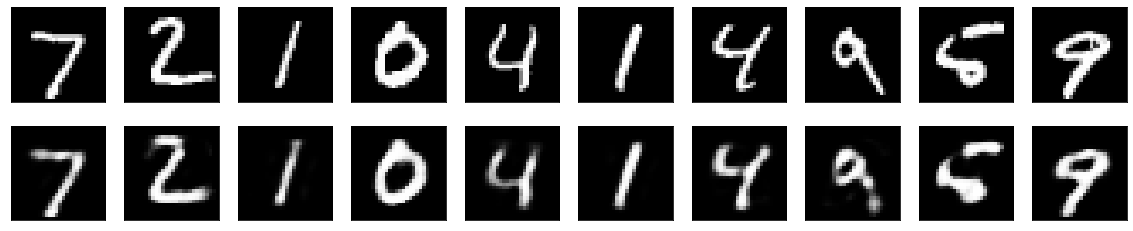

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
